In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install semopy
import semopy as sem
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import json
import warnings
warnings.filterwarnings("ignore")
!rm rf statannot
!git clone https://github.com/ellariel/statannot
from statannot.statannot import add_stat_annotation

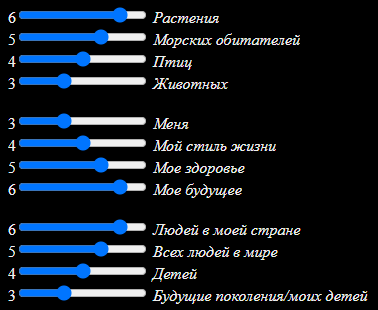

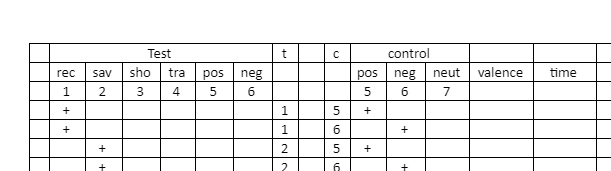


In [49]:
data = pd.read_csv('/content/drive/MyDrive/pilot_data_v1.0.csv', sep=';')
print(len(data), int(len(data) / 32))
rec, sav, sho, tra, pos, neg, neut = 1, 2, 3, 4, 5, 6, 7
eco = [rec, sav, sho, tra]

5856 183


In [50]:
print(len(data.drop_duplicates(subset=['id'])[['age', 'gender', 'income', 'work', 'car']].dropna()))
data.drop_duplicates(subset=['id']).describe().T[17:23]

166


,count,mean,std,min,25%,50%,75%,max
age,179.0,23.726257,7.260632,14.0,20.0,21.0,25.00,55.0
gender,180.0,0.283333,0.451874,0.0,0.0,0.0,1.00,1.0
income,172.0,1.988372,1.333282,1.0,1.0,1.0,2.25,6.0
work,181.0,0.469613,0.500460,0.0,0.0,0.0,1.00,1.0
car,183.0,0.568306,0.496671,0.0,0.0,1.0,1.00,1.0
edu,182.0,2.714286,0.754884,1.0,3.0,3.0,3.00,4.0


In [ ]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
def make_xy(x, y):
  df = None
  for i in range(len(x)):
    d = pd.DataFrame(y[i])
    d['_group'] = x[i]
    df = pd.concat([df, d], ignore_index=True)
  return df.rename(columns={df.columns[0]:'y', '_group':'x'})

69 - dropout
n=114, inc/con mean diff 67.9 ms, eco-neg/eco-pos mean diff 166.5 ms
congruent time less than incongruent: p=0.006
eco→positive time less than incongruent: p=0.000
eco→negative time greater than congruent: p=0.000
eco→positive time less than eco→negative: p=0.000
congruent vs incongruent (two-sided): p=0.013
eco→positive vs eco→negative(two-sided): p=0.000
♣ rec→positive less eco→negative: p=0.000
♠ sav→positive less eco→negative: p=0.000
♦ sho→positive less eco→negative: p=0.000
♥ tra→positive less eco→negative: p=0.000


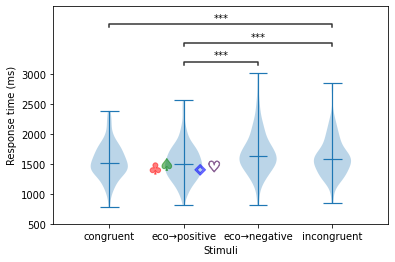

In [ ]:
d = data.copy()
invalid = d[d.time > 4000].id.unique()
#d.time = d.time.apply(lambda x: 4000 if x > 4000 else x) #for test reasons
d = d[d.id.apply(lambda x: not x in invalid)]
print(f'{len(invalid)} - dropout')
con = d[((d.test == neg) & (d.ctrl == neg)) |
        ((d.test == pos) & (d.ctrl == pos))].groupby(by=['id']).aggregate(np.mean) #congruent
inc = d[((d.test == neg) & (d.ctrl == pos)) |
        ((d.test == pos) & (d.ctrl == neg))].groupby(by=['id']).aggregate(np.mean) #incongruent
eco_pos = d[d.test.apply(lambda x: x in eco) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
eco_neg = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neg)].groupby(by=['id']).aggregate(np.mean)
rec_pos = d[(d.test == rec) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sav_pos = d[(d.test == sav) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
sho_pos = d[(d.test == sho) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
tra_pos = d[(d.test == tra) & (d.ctrl == pos)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(con)}, inc/con mean diff {inc.time.mean()-con.time.mean():.1f} ms, eco-neg/eco-pos mean diff {eco_neg.time.mean()-eco_pos.time.mean():.1f} ms')
_, p1 = wilcoxon(con.time, inc.time, alternative='less'); print(f'congruent time less than incongruent: p={p1:.3f}')
_, p2 = wilcoxon(eco_pos.time, inc.time, alternative='less'); print(f'eco→positive time less than incongruent: p={p2:.3f}')
_, p3 = wilcoxon(eco_neg.time, con.time, alternative='greater'); print(f'eco→negative time greater than congruent: p={p3:.3f}')
_, p4 = wilcoxon(eco_pos.time, eco_neg.time, alternative='less'); print(f'eco→positive time less than eco→negative: p={p4:.3f}')
_, p5 = wilcoxon(con.time, inc.time); print(f'congruent vs incongruent (two-sided): p={p5:.3f}')
_, p6 = wilcoxon(eco_pos.time, eco_neg.time); print(f'eco→positive vs eco→negative(two-sided): p={p6:.3f}')

_, p = wilcoxon(rec_pos.time, eco_neg.time, alternative='less'); print(u"\u2663" + f' rec→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(sav_pos.time, eco_neg.time, alternative='less'); print(u'\u2660' + f' sav→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(sho_pos.time, eco_neg.time, alternative='less'); print(u'\u2666' + f' sho→positive less eco→negative: p={p:.3f}')
_, p = wilcoxon(tra_pos.time, eco_neg.time, alternative='less'); print(u'\u2665' + f' tra→positive less eco→negative: p={p:.3f}')

fig, ax = plt.subplots()
y = [con.time, eco_pos.time, eco_neg.time, inc.time]
x = ['congruent', 'eco→positive', 'eco→negative', 'incongruent']
v = ax.violinplot(y, showmedians=True, showmeans=False, showextrema=True)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = v[partname]
    vp.set_linewidth(1.2)
for vp in v['bodies']:
    vp.set_alpha(0.3)
ax.scatter([1.60], [rec_pos.time.median()], 150, c='r', alpha=0.5, marker=r'$\clubsuit$', label="rec")
ax.scatter([1.75], [sav_pos.time.median()], 150, c='g', alpha=0.5, marker=r'$\spadesuit$', label="sav")
ax.scatter([2.20], [sho_pos.time.median()], 150, c='b', alpha=0.5, marker=r'$\diamond$', label="sho")
ax.scatter([2.40], [tra_pos.time.median()], 150, c=4, alpha=0.5, marker=r'$\heartsuit$', label="tra")
ax.set_ylabel('Response time (ms)')
ax.set_xlabel('Stimuli')
set_axis_style(ax, x)
xy = make_xy(x, y)
annot = ['***' , '***', '***']
pairs = [(x[0], x[3]), (x[1], x[2]), (x[1], x[3])]
add_stat_annotation(ax, data=xy, x='x', y='y', order=x, box_pairs=pairs, perform_stat_test=False,
                    text_format='star', loc='inside', verbose=0, text_annot_custom=annot,
                    left_offset=1, pvalues=[0.0 for i in pairs])
plt.yticks(np.arange(500, 3500, 500))
plt.savefig('fig1.png', dpi=300, quality=100, fomat='png')
plt.show()

In [ ]:
print(len(eco_pos))
print('Male ',len(eco_pos[eco_pos.gender == 1]))
print('Female ',len(eco_pos[eco_pos.gender != 1]))
eco_pos.describe().T[16:23]

114
Male  35
Female  79


,count,mean,std,min,25%,50%,75%,max
age,110.0,22.854545,6.282109,14.0,19.0,20.5,23.0,50.0
gender,112.0,0.312500,0.465596,0.0,0.0,0.0,1.0,1.0
income,108.0,1.981481,1.332424,1.0,1.0,1.0,3.0,6.0
work,112.0,0.473214,0.501526,0.0,0.0,0.0,1.0,1.0
car,114.0,0.640351,0.482016,0.0,0.0,1.0,1.0,1.0
edu,113.0,2.699115,0.777874,1.0,3.0,3.0,3.0,4.0
device,114.0,0.368421,0.484506,0.0,0.0,0.0,1.0,1.0


43 - dropout
n=140
eco valence median: 3.125
pos vs neg mean diff 0.38 pts
eco vs neg mean diff 0.29 pts
eco vs pos mean diff -0.09 pts
positive valence greater than negative: p=0.000
eco valence greater than negative: p=0.000
positive valence greater than eco: p=0.133
♣ rec valence greater negative: p=0.001
♠ sav valence greater negative: p=0.002
♦ sho valence greater negative: p=0.013
♥ tra valence greater negative: p=0.003


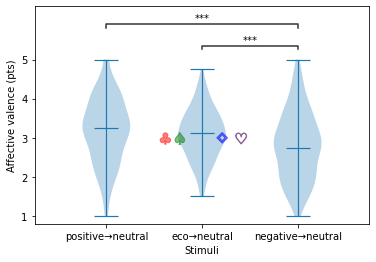

In [ ]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
invalid = {*a, *b}
print(f'{len(invalid)} - dropout')
d = d[d.id.apply(lambda x: not x in invalid)]
pos_neut = d[(d.test == pos) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #positive-neutral
neg_neut = d[(d.test == neg) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #negative-neutral
eco_neut = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
rec_neut = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_neut = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_neut = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_neut = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
print(f'n={len(pos_neut)}')
print(f'eco valence median: {eco_neut.valence.median()}')
print(f'pos vs neg mean diff {pos_neut.valence.mean()-neg_neut.valence.mean():.2f} pts')
print(f'eco vs neg mean diff {eco_neut.valence.mean()-neg_neut.valence.mean():.2f} pts') 
print(f'eco vs pos mean diff {eco_neut.valence.mean()-pos_neut.valence.mean():.2f} pts')
_, p1 = wilcoxon(pos_neut.valence, neg_neut.valence, alternative='greater'); print(f'positive valence greater than negative: p={p1:.3f}')
_, p2 = wilcoxon(eco_neut.valence, neg_neut.valence, alternative='greater'); print(f'eco valence greater than negative: p={p2:.3f}')
_, p3 = wilcoxon(pos_neut.valence, eco_neut.valence, alternative='greater'); print(f'positive valence greater than eco: p={p3:.3f}')

_, p = wilcoxon(rec_neut.valence, neg_neut.valence, alternative='greater'); print(u"\u2663" + f' rec valence greater negative: p={p:.3f}')
_, p = wilcoxon(sav_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2660' + f' sav valence greater negative: p={p:.3f}')
_, p = wilcoxon(sho_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2666' + f' sho valence greater negative: p={p:.3f}')
_, p = wilcoxon(tra_neut.valence, neg_neut.valence, alternative='greater'); print(u'\u2665' + f' tra valence greater negative: p={p:.3f}')

fig, ax = plt.subplots()
y = [pos_neut.valence, eco_neut.valence, neg_neut.valence]
x = ['positive→neutral', 'eco→neutral', 'negative→neutral']
v = ax.violinplot(y, showmedians=True, showmeans=False)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = v[partname]
    vp.set_linewidth(1.2)
for vp in v['bodies']:
    vp.set_alpha(0.3)
ax.scatter([1.60], [rec_neut.valence.median()], 150, c='r', alpha=0.5, marker=r'$\clubsuit$', label="rec")
ax.scatter([1.75], [sav_neut.valence.median()], 150, c='g', alpha=0.5, marker=r'$\spadesuit$', label="sav")
ax.scatter([2.20], [sho_neut.valence.median()], 150, c='b', alpha=0.5, marker=r'$\diamond$', label="sho")
ax.scatter([2.40], [tra_neut.valence.median()], 150, c=4, alpha=0.5, marker=r'$\heartsuit$', label="tra")
ax.set_ylabel('Affective valence (pts)')
ax.set_xlabel('Stimuli')
set_axis_style(ax, x)
xy = make_xy(x, y)
annot = ['***' , '***']
pairs = [(x[0], x[2]), (x[1], x[2])]
add_stat_annotation(ax, data=xy, x='x', y='y', order=x, box_pairs=pairs, perform_stat_test=False,
                    text_format='star', loc='inside', verbose=0, text_annot_custom=annot,
                    left_offset=1, pvalues=[0.0 for i in pairs])
plt.yticks(np.arange(1, 6, 1))
plt.savefig('fig2.png', dpi=300, quality=100, fomat='png')
plt.show()

In [ ]:
print(f'n={len(eco_neut)}')
print('Male ',len(eco_neut[eco_neut.gender == 1]))
print('Female ',len(eco_neut[eco_neut.gender != 1]))
eco_pos.describe().T[16:23]

n=140
Male  33
Female  107


,count,mean,std,min,25%,50%,75%,max
age,110.0,22.854545,6.282109,14.0,19.0,20.5,23.0,50.0
gender,112.0,0.312500,0.465596,0.0,0.0,0.0,1.0,1.0
income,108.0,1.981481,1.332424,1.0,1.0,1.0,3.0,6.0
work,112.0,0.473214,0.501526,0.0,0.0,0.0,1.0,1.0
car,114.0,0.640351,0.482016,0.0,0.0,1.0,1.0,1.0
edu,113.0,2.699115,0.777874,1.0,3.0,3.0,3.0,4.0
device,114.0,0.368421,0.484506,0.0,0.0,0.0,1.0,1.0


In [ ]:
d = data.copy()
a = d[(d.test == neg) & (d.ctrl == neg) & (d.valence > 3)].id.unique()
b = d[(d.test == pos) & (d.ctrl == pos) & (d.valence < 3)].id.unique()
c = d[(d.q1 == 6) & (d.q2 == 5) & (d.q3 == 4) & (d.q4 == 3) & \
      (d.q5 == 3) & (d.q6 == 4) & (d.q7 == 5) & (d.q8 == 6) & \
      (d.q9 == 6) & (d.q10 == 5) & (d.q11 == 4) & (d.q12 == 3)].id.unique()
invalid = {*a, *b, *c}
print(f'{len([i for i in c if i not in {*a, *b}])} - dropout')
print(f'{len(invalid)} - total dropout')
d = d[d.id.apply(lambda x: not x in invalid)]#.dropna() #6 uncomplete
rec_v = d[(d.test == rec) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sav_v = d[(d.test == sav) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
sho_v = d[(d.test == sho) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
tra_v = d[(d.test == tra) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean)
eco_v = d[d.test.apply(lambda x: x in eco) & (d.ctrl == neut)].groupby(by=['id']).aggregate(np.mean) #eco-neutral
print(f'n={len(eco_v)}')
cor_p = pearsonr(eco_v.valence, eco_v.time)
cor_s = spearmanr(eco_v.valence, eco_v.time)
print(f'Correlation between valence and responce time:')
print(f'Pearson r={cor_p[0]:.3f} p={cor_p[1]:.3f}')
print(f'Spearman r={cor_s[0]:.3f} p={cor_s[1]:.3f}')

15 - dropout
58 - total dropout
n=125
Correlation between valence and responce time:
Pearson r=0.070 p=0.439
Spearman r=0.080 p=0.377


In [ ]:
pos_v = eco_v[(eco_v.valence > 3)]
print(f'n={len(pos_v)} with positive valence')
print('Male ',len(pos_v[pos_v.gender == 1]))
print('Female ',len(pos_v[pos_v.gender != 1]))
pos_v.describe().T[16:23]

n=60 with positive valence
Male  19
Female  41


,count,mean,std,min,25%,50%,75%,max
age,60.0,23.533333,6.830804,15.0,20.0,21.0,24.25,47.0
gender,59.0,0.322034,0.471267,0.0,0.0,0.0,1.00,1.0
income,58.0,2.000000,1.311220,1.0,1.0,1.0,3.00,6.0
work,60.0,0.400000,0.494032,0.0,0.0,0.0,1.00,1.0
car,60.0,0.450000,0.501692,0.0,0.0,0.0,1.00,1.0
edu,60.0,2.716667,0.738566,1.0,3.0,3.0,3.00,4.0
device,60.0,0.416667,0.497167,0.0,0.0,0.0,1.00,1.0


valence median: 3.0
n=60


                    Value
DoF            212.000000
DoF Baseline   240.000000
chi2           300.535878
chi2 p-value     0.000060
chi2 Baseline  822.488499
CFI              0.848004
GFI              0.634602
AGFI             0.586342
NFI              0.634602
TLI              0.827929
RMSEA            0.084133
AIC             71.499502
BIC            157.367629
LogLik           5.250249


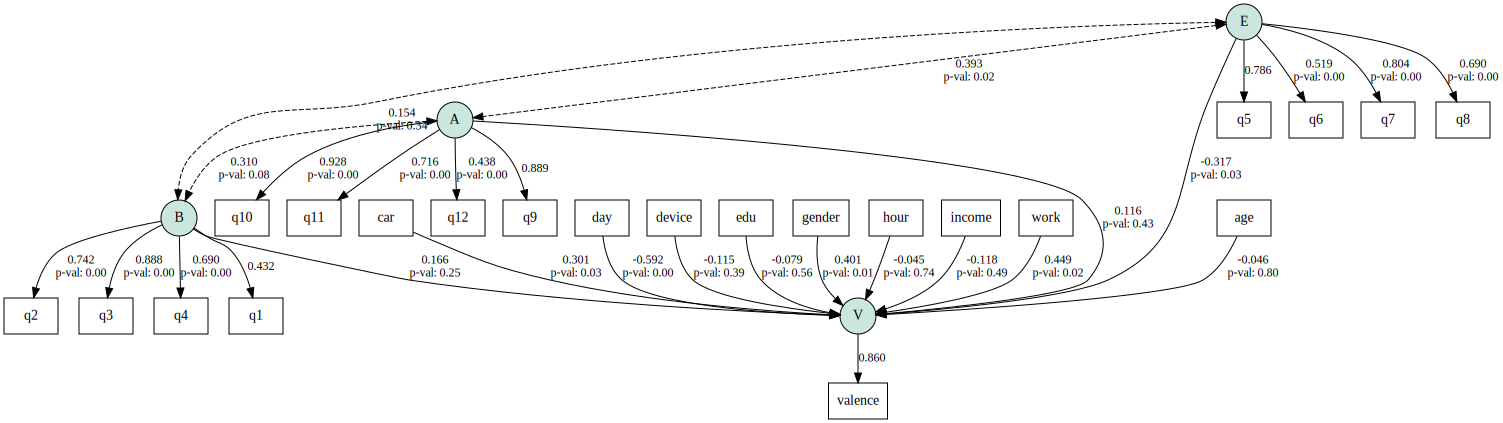

In [ ]:
#https://arxiv.org/pdf/2106.01140.pdf
print(f'valence median: {eco_v.valence.median()}')
d = pos_v.copy() #positive only
d.time = np.log(d.time)
d.age = np.log(d.age)
print(f'n={len(d)}')
formula = """
B =~ q1 + q2 + q3 + q4
E =~ q5 + q6 + q7 + q8
A =~ q9 + q10 + q11 + q12
V =~ valence
V ~ B + E + A + gender + age + edu + income + car  + work + device + day + hour
"""
model = sem.Model(formula)
model.fit(d, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=500, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "sem.pdf", plot_covs=True, std_ests=True, show=True)

In [ ]:
model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,V,~,B,0.137421,0.119807,1.14702,0.251373
1,V,~,E,-0.079549,0.0376398,-2.11343,0.0345637
2,V,~,A,0.027612,0.0347154,0.795393,0.426385
3,V,~,gender,0.314218,0.112831,2.78485,0.00535518
4,V,~,age,-0.068391,0.27082,-0.252534,0.800628
5,V,~,edu,-0.039484,0.0676388,-0.583742,0.559394
6,V,~,income,-0.033326,0.0486215,-0.685416,0.493081
7,V,~,car,0.221514,0.104321,2.12339,0.0337213
8,V,~,work,0.335881,0.13998,2.39949,0.0164179
9,V,~,device,-0.085620,0.099904,-0.857027,0.39143
